## Figure of pool contours

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib as mpl
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import warnings
warnings.filterwarnings('ignore')

In [2]:
def findBottInd(hfac):
    
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    return BottomInd

def ConcAreaShelf(Tr, hfac, ra, bathy):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx). 
       Conc = cocetration near bottom (nt,ny,nx)
       Area = 2D array of cell areas on shelf (ny,nx)
       NOTE: Everything below the canyon rim is masked out'''
    
    sh = np.shape(Tr)
    nx = sh[3]
    ny = sh[2]
    nz = sh[1]
    nt = sh[0]
    
    ConcArea = np.empty((nt,ny,nx))
    Conc = np.empty((nt,ny,nx))
    ConcFiltered = np.empty((nt,ny,nx))
    Area = np.empty((nt,ny,nx))
    
    BottomInd = findBottInd(hfac)  
    
    for tt in range(nt):
        for j in range(nx):
            for i in range(ny):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                ConcArea[tt,i,j] = TrBottom*ra[i,j]
                Conc[tt,i,j] = TrBottom
                Area[tt,i,j] = ra[i,j]
                
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    maskShelf = np.ma.masked_invalid(ConcFiltered) 
    
    return (np.ma.masked_invalid(ConcArea),
            np.ma.masked_invalid(ConcFiltered),
            np.ma.masked_invalid(Area))

def ConcAreaPool(Tr, hfac, ra, bathy):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx). 
       Conc = cocetration near bottom (nt,ny,nx)
       Area = 2D array of cell areas on shelf (ny,nx)
       NOTE: Everything below the canyon rim is masked out'''
    
    sh = np.shape(Tr)
    nx = sh[3]
    ny = sh[2]
    nz = sh[1]
    nt = sh[0]
    
    ConcArea = np.empty((nt,ny,nx))
    Conc = np.empty((nt,ny,nx))
    ConcFiltered = np.empty((nt,ny,nx))
    Area = np.empty((nt,ny,nx))
    
    BottomInd = findBottInd(hfac)  
    
    for tt in range(nt):
        for j in range(nx):
            for i in range(ny):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                if TrBottom > 0.0:
                    ConcArea[tt,i,j] = TrBottom*ra[i,j]
                    Conc[tt,i,j] = TrBottom
                    Area[tt,i,j] = ra[i,j]
                else:
                    ConcArea[tt,i,j] = np.NaN
                    Conc[tt,i,j] = np.NaN
                    Area[tt,i,j] = np.NaN
                
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    maskShelf = np.ma.masked_invalid(ConcFiltered) 
    
    return (np.ma.masked_invalid(ConcArea),
            np.ma.masked_invalid(ConcFiltered),
            np.ma.masked_invalid(Area))

In [23]:
# Cross-shelf velocity, Plot1
def Plot1anom(gs_ax,Tr_slice,Tr_sliceNoC,zslice,yind,xslice,color='black',line='-'): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in x-z (nt,nz,nx)
       tslice: advective phase slice to average over.
       yind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax, xticks=[])
    
    Trplot = np.ma.array(np.nanmean(Tr_slice.isel(T=tslice).data-Tr_sliceNoC.isel(T=tslice).data,0),
                         mask=MaskCNoC[:,yind,:])
    
    CS = ax.contour(grid.X[xslice]/1000,grid.Z[zslice],
                    Trplot[zslice,xslice],
                    [0.5],
                    colors=sns.xkcd_rgb[color],
                    linewidths=[2],linestyle=line,
                    )
    zc = CS.collections[0]
    plt.setp(zc, linestyle=line)
    
    ax.plot(grid.X[xslice]/1000,-grid.Depth[yind,xslice],
           '-',
           color='0.5',
           linewidth=2,
           )
    
    ax.set_axis_bgcolor((255/255.0, 255/255.0, 255/255.0))
    
    return ax

In [24]:
def Plot2anom(gs_ax,Tr_slice,Tr_sliceNoC,yslice,zslice,xind,color='black',line='-'): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in y-z (nt,nz,ny)
       tslice: advective phase slice to average over.
       xind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    
    
    Trplot = np.ma.array(np.nanmean(Tr_slice.isel(T=tslice).data-Tr_sliceNoC.isel(T=tslice).data,0),
                         mask=MaskCNoC[:,:,xind])
    
     
    CS = ax.contour(grid.Y[yslice]/1000,grid.Z[zslice],
                    (Trplot[zslice,yslice]),
                    [0.5],
                    colors=sns.xkcd_rgb[color],
                    linewidths=[2],linestyle=line )
    zc = CS.collections[0]
    plt.setp(zc, linestyle=line)
    
    SB = ax.plot(grid.Y[yslice]/1000,-grid.Depth[yslice,xind],
                 '-',
                 color='0.5',
                 linewidth=2)
    
    ax.set_axis_bgcolor((255/255.0, 255/255.0, 255/255.0))
    
    return ax

In [25]:
def Plot3anom(gs_ax,ConcFilt,tslice,xslice,yslice,xind,yind,color='black',line='-',label='base'):
    
    ax = plt.subplot(gs_ax)
    BAC = np.nanmean(ConcFilt[tslice,yslice,xslice],axis=0)
    
    
    CS = ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,BAC,
                    [0.5],
                    colors=sns.xkcd_rgb[color],
                    linewidths=[2])
    zc = CS.collections[0]
    plt.setp(zc, linestyle=line)
      
    ax.set_axis_bgcolor((255/255.0, 255/255.0, 255/255.0))
    
    
    SB = ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,
                     grid.Depth[yslice,xslice],
                    [150.0],
                    colors=['0.5'],
                    linewidths=[2] )
    
    ax.axhline(grid.Y[yind]/1000,color='k',linestyle='--')
    ax.axvline(grid.X[xind]/1000,color='k',linestyle='--')
    
    CS.collections[0].set_label(label)
    plt.legend(bbox_to_anchor=(1.7,1.75),ncol=2, labelspacing=0.1, columnspacing=0.1,fontsize=10)

    return ax
    

In [26]:
def PlotAnomTimeSeries(ax0,ax1,ax2,AWConcPool,AreaPool,Area,ConcAreaWeighted,color='black',label='base',line='-'):
    
    BACpool = np.nansum(np.nansum(np.ma.masked_array((AWConcPool),mask=maskExpandSB[:,yslice_bac,xslice_bac]),axis=1),axis=1)
    AREApool = np.nansum(np.nansum(np.ma.masked_array((AreaPool),mask=maskExpandSB[:,yslice_bac,xslice_bac]),axis=1),axis=1)
    AREA = np.nansum(np.nansum(np.ma.masked_array((Area),mask=maskExpandSB[:,yslice_bac,xslice_bac]),axis=1),axis=1)
    BACCan = np.nansum(np.nansum(np.ma.masked_array((ConcAreaWeighted),mask=maskExpandSB[:,yslice_bac,xslice_bac]),axis=1),axis=1)
    
    ax0.plot(np.arange(len(BACpool))/2,(BACpool)/AREApool,linestyle=line,
            color = sns.xkcd_rgb[color],
            linewidth = 2,label=label)
    ax1.plot(np.arange(len(BACpool))/2,(AREApool)/1E9,linestyle=line,
            color = sns.xkcd_rgb[color],
            linewidth = 2,label=label)
    ax2.plot(np.arange(len(BACpool))/2,(BACCan)/AREA,linestyle=line,
            color = sns.xkcd_rgb[color],
            linewidth = 2,label=label)
    
    
    
    return(ax0,ax1,ax2) 
       

In [7]:
import canyon_records 
import nocanyon_records

In [8]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [9]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

grid_fileNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
gridNoC = xr.open_dataset(grid_fileNoC)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

ptracersNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc'
ptracersNoC = xr.open_dataset(ptracersNoC_file)

#RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/RhoRef'))
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [10]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xslice=slice(100,360)
yslice=slice(120,310)

tslice = slice(4,10)

xind = 240
yind = 267 # y index for alongshore cross-section
zind = 27

zslice = slice(10,22)
# plot2
zslice_2 = slice(10,32)
# plot 3
yslice_bac = slice(227,305)
xslice_bac = slice(120,360)

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)

hFacmaskedNoC = np.ma.masked_values(gridNoC.HFacC.data, 0)
MaskCNoC = np.ma.getmask(hFacmaskedNoC)

MaskExpand = np.expand_dims(MaskC,0) 
MaskExpand = MaskExpand + np.zeros((ptracers.Tr1).shape)    

In [11]:
BottInd = findBottInd(grid.HFacC.data)
BottIndNoC = findBottInd(gridNoC.HFacC.data)

In [12]:
# Find mask shelf bottom

hold_maskSB = np.empty((ny,nx))

for j in range (nx):
    for i in range(ny):
        if  abs(BottInd[i,j]-BottIndNoC[i,j]) <= 1:
            hold_maskSB[i,j] = 1
        else:
            hold_maskSB[i,j]= 0
    
maskSB = np.ma.masked_equal(hold_maskSB,0)     
bathyMasked = np.ma.masked_less(-gridNoC.Depth, -152.5)

MASK_SB = np.ma.mask_or(bathyMasked.mask, maskSB.mask)

maskExpandSB = np.expand_dims(MASK_SB,0) 
maskExpandSB = maskExpandSB + np.zeros((nt,ny,nx))   


In [13]:
for ii in range(len(records)):
    print(ii,records[ii].name)
select_rec = [0,2,12,15,5,9,16]
    
records2 = [records[0],
            records[2],
            records[12],
            records[15],
            records[5],
            records[9],
            records[16],
            ]
recordsNoC2 = [recordsNoC[0],
               recordsNoC[2],
               recordsNoC[12],
               recordsNoC[15],
               recordsNoC[5],
               recordsNoC[9],
               recordsNoC[16],
               ]

linesty = ['-','-','-','-','-','-','-']



0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
6 CNTDIFF_run67
7 CNTDIFF_run51
8 CNTDIFF_run69
9 CNTDIFF_run71
10 3DVISC_run01
11 3DVISC_run02
12 3DVISC_run03
13 3DVISC_run04
14 3DVISC_run05
15 3DVISC_run06
16 LOWEST_BF_run01
17 LOWEST_BF_run03
18 LOWEST_BF_run07
19 LOWEST_BF_run11


done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations


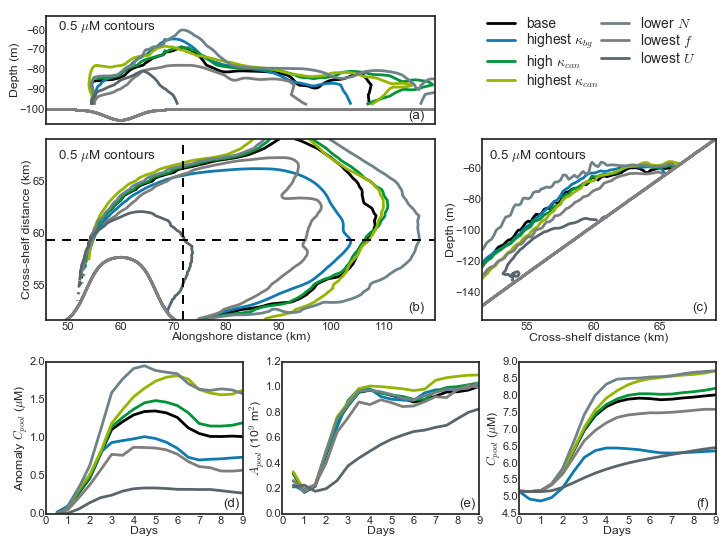

In [31]:
cmap_name = cmo.cm.balance
sns.set_context('paper')
sns.set_style('white')

#plt.rcParams['font.size'] = 8.0

f = plt.figure(figsize = (7.4,5.5)) # 19.0cm = 7.4in, 115cm = 4.52in

gs = gspec.GridSpec(2, 1, height_ratios=[1.6,0.8])

gs1 = gspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0],height_ratios=[0.6,1],width_ratios=[1,0.6],
                                    wspace=0.15,hspace=0.1 )
gs2 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1])

ax4 = plt.subplot(gs2[0,0])
ax5 = plt.subplot(gs2[0,1])
ax6 = plt.subplot(gs2[0,2])


jj=0
for rec,recNoC in zip(records2,recordsNoC2):
    
    ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers = xr.open_dataset(ptracers_file)

    ptracersNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    ptracersNoC = xr.open_dataset(ptracersNoC_file)

    ConcAreaWeighted, ConcFilt, Area = ConcAreaShelf(ptracers.Tr1.data, 
                                                     grid.HFacC.data, 
                                                     grid.rA.data,
                                                     grid.Depth.data)

    ConcAreaWeightedNoC, ConcFiltNoC, AreaNoC = ConcAreaShelf(ptracersNoC.Tr1.data,gridNoC.HFacC.data, 
                                                                     gridNoC.rA.data, gridNoC.Depth.data)
    print('done getting bottom concentrations')
    ax1=Plot1anom(gs1[0,0],ptracers.Tr1.isel(Y=yind),ptracersNoC.Tr1.isel(Y=yind),
              zslice,267,xslice,color=rec.color2,line=linesty[jj]) # x-z contours conc

    ax2=Plot2anom(gs1[1,1],ptracers.Tr1.isel(X=xind),ptracersNoC.Tr1.isel(X=xind),
              yslice_bac,zslice_2,250,color=rec.color2,line=linesty[jj]) # bottom concentration

    ax3=Plot3anom(gs1[1,0],np.ma.masked_array(ConcFilt-ConcFiltNoC,mask=maskExpandSB),
              tslice,xslice,yslice_bac,250,267,color=rec.color2,line=linesty[jj],label=rec.label)

    # -----------------------------------------------------------------------------------------
    
    AWConcPool, ConcPool, AreaPool = ConcAreaPool(ptracers.Tr1.data[:,:,yslice_bac,xslice_bac]-ptracersNoC.Tr1.data[:,:,yslice_bac,xslice_bac], 
                                                  gridNoC.HFacC.data[:,yslice_bac,xslice_bac], 
                                                  gridNoC.rA.data[yslice_bac,xslice_bac],
                                                  gridNoC.Depth.data[yslice_bac,xslice_bac])

    ConcAreaWeighted, ConcFilt, Area = ConcAreaShelf(ptracers.Tr1.data[:,:,yslice_bac,xslice_bac], 
                                                     grid.HFacC.data[:,yslice_bac,xslice_bac], 
                                                     grid.rA.data[yslice_bac,xslice_bac],
                                                     grid.Depth.data[yslice_bac,xslice_bac])

    
    print('done getting bottom concentrations')
    
    ax4,ax5,ax6 = PlotAnomTimeSeries(ax4,ax5,ax6,AWConcPool,AreaPool,Area,ConcAreaWeighted,
                                     color=rec.color2,
                                     line=linesty[jj])

    jj=jj+1
    # -----------------------------------------------------------------------------------------

ax1.set_ylabel('Depth (m)',labelpad=-0.2)
ax1.text(0.03,0.87,'0.5 $\mu$M contours',transform=ax1.transAxes)
ax1.text(0.93,0.05,'(a)',transform=ax1.transAxes)

ax2.set_ylabel('Depth (m)',labelpad=0.0)
ax2.set_xlabel('Cross-shelf distance (km)',labelpad=0.3)
ax2.text(0.03,0.89,'0.5 $\mu$M contours',transform=ax2.transAxes)    
ax2.text(0.9,0.05,'(c)',transform=ax2.transAxes)

ax3.text(0.03,0.89,'0.5 $\mu$M contours',transform=ax3.transAxes)
ax3.set_xlabel('Alongshore distance (km)',labelpad=0.0)
ax3.set_ylabel('Cross-shelf distance (km)',labelpad=0.3)
ax3.text(0.93,0.05,'(b)',transform=ax3.transAxes)


ax4.set_xlabel('Days',labelpad=0.0)
ax4.set_ylabel('Anomaly $C_{pool}$ ($\mu$M)',labelpad=0)
ax4.text(0.9,0.05,'(d)',transform=ax4.transAxes)

ax5.set_xlabel('Days',labelpad=0.0)
ax5.set_ylabel('$A_{pool}$ (10$^9$ m$^2$)',labelpad=0)
ax5.text(0.9,0.05,'(e)',transform=ax5.transAxes)

ax6.set_xlabel('Days',labelpad=0.0)
ax6.set_ylabel('$C_{pool}$ ($\mu$M)',labelpad=0)
ax6.text(0.9,0.05,'(f)',transform=ax6.transAxes)

ax6.tick_params(axis='y', pad=0.7)
ax4.tick_params(axis='y', pad=0.7)
ax5.tick_params(axis='y', pad=0.7)

ax6.tick_params(axis='x', pad=1.3)
ax4.tick_params(axis='x', pad=1.3)
ax5.tick_params(axis='x', pad=1.3)

ax2.tick_params(axis='y', pad=0.7)
ax3.tick_params(axis='y', pad=0.7)
ax1.tick_params(axis='y', pad=0.7)

ax2.tick_params(axis='x', pad=1.3)
ax3.tick_params(axis='x', pad=1.3)
ax1.tick_params(axis='x', pad=1.3)

plt.tight_layout()

plt.savefig('figure3.eps',format='eps', bbox_inches='tight')




## BAC timeseries

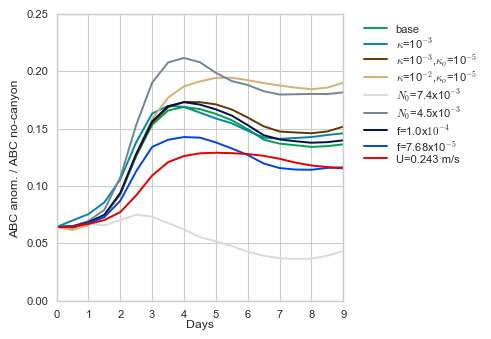

In [15]:
records2 = [records[0],
            records[2],
            records[12],
            records[14],
            records[4],
            records[5],
            records[6],
            records[7],
            records[15]]
recordsNoC2 = [recordsNoC[0],
               recordsNoC[2],
               recordsNoC[12],
               recordsNoC[14],
               recordsNoC[5],
               recordsNoC[5],
               recordsNoC[6],
               recordsNoC[7],
               recordsNoC[15]]

sns.set_context('paper')
sns.set_style('whitegrid')

#plt.rcParams['font.size'] = 8

f,ax = plt.subplots(1,1,figsize = (3.7,3.7)) # 19.0cm = 7.4in, 115cm = 4.52in

labels = []

for rec,recNoC in zip(records2,recordsNoC2):
    
    ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers = xr.open_dataset(ptracers_file)

    ptracersNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    ptracersNoC = xr.open_dataset(ptracersNoC_file)

    ConcAreaWeighted, ConcFilt, Area = ConcAreaShelf(ptracers.Tr1.data, grid.HFacC.data, grid.rA.data,
                                                 grid.Depth.data)

    ConcAreaWeightedNoC, ConcFiltNoC, AreaNoC = ConcAreaShelf(ptracersNoC.Tr1.data,gridNoC.HFacC.data, 
                                                                     gridNoC.rA.data, gridNoC.Depth.data)
    
    
    BAC = [np.sum(np.sum((ConcAreaWeighted[:,yslice_bac,xslice_bac].data-
                          ConcAreaWeightedNoC[:,yslice_bac,xslice_bac].data),
                         axis=1),axis=1)]
    BAC0 = [np.sum(np.sum(ConcAreaWeighted[:,yslice_bac,xslice_bac].data,axis=1),axis=1)]
    
    
    CS = ax.plot(np.arange(19)/2,np.squeeze(np.array(BAC))[:]/np.squeeze(np.array(BAC0))[:],
                 color=sns.xkcd_rgb[rec.color],
                 label=rec.label)
      
    labels.append(rec.label)

    
ax.set_xlabel('Days',labelpad=0.3)
ax.set_ylabel('ABC anom. / ABC no-canyon')
#ax.set_ylim(0.4,3)
plt.legend(labels,ncol=1,bbox_to_anchor=(1.5,1),labelspacing=0.1, columnspacing=0.15)


plt.savefig('fig_BAC_timeseries_selected.eps',format='eps',bbox_inches='tight')
plt.show()


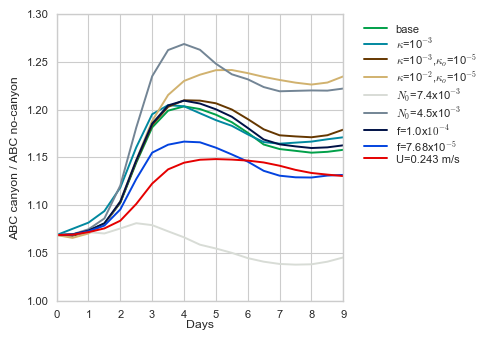

In [16]:
records2 = [records[0],
            records[2],
            records[12],
            records[14],
            records[4],
            records[5],
            records[6],
            records[7],
            records[15]]
recordsNoC2 = [recordsNoC[0],
               recordsNoC[2],
               recordsNoC[12],
               recordsNoC[14],
               recordsNoC[5],
               recordsNoC[5],
               recordsNoC[6],
               recordsNoC[7],
               recordsNoC[15]]

sns.set_context('paper')
sns.set_style('whitegrid')

#plt.rcParams['font.size'] = 8

f,ax = plt.subplots(1,1,figsize = (3.7,3.7)) # 19.0cm = 7.4in, 115cm = 4.52in

labels = []

for rec,recNoC in zip(records2,recordsNoC2):
    
    ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers = xr.open_dataset(ptracers_file)

    ptracersNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    ptracersNoC = xr.open_dataset(ptracersNoC_file)

    ConcAreaWeighted, ConcFilt, Area = ConcAreaShelf(ptracers.Tr1.data, grid.HFacC.data, grid.rA.data,
                                                 grid.Depth.data)

    ConcAreaWeightedNoC, ConcFiltNoC, AreaNoC = ConcAreaShelf(ptracersNoC.Tr1.data,gridNoC.HFacC.data, 
                                                                     gridNoC.rA.data, gridNoC.Depth.data)
    
    
    BAC = [np.sum(np.sum(ConcAreaWeighted[:,yslice_bac,xslice_bac].data,axis=1),axis=1)]
    BAC0 = [np.sum(np.sum(ConcAreaWeightedNoC[:,yslice_bac,xslice_bac].data,axis=1),axis=1)]
    
    
    CS = ax.plot(np.arange(19)/2,np.squeeze(np.array(BAC))[:]/np.squeeze(np.array(BAC0))[:],
                 color=sns.xkcd_rgb[rec.color],
                 label=rec.label)
      
    labels.append(rec.label)

    
ax.set_xlabel('Days',labelpad=0.3)
ax.set_ylabel('ABC canyon / ABC no-canyon')
#ax.set_ylim(0.4,3)
plt.legend(labels,ncol=1,bbox_to_anchor=(1.5,1),labelspacing=0.1, columnspacing=0.15)


plt.savefig('fig_BACampli_timeseries_selected.eps',format='eps',bbox_inches='tight')
plt.show()
